# Population vs. Median Home Prices
#### *Linear Regression with Single Variable*

*Note, this notebook requires Spark 2.0+*

In [1]:
import os
import sys
import findspark
findspark.init('/home/jovyan/base/spark-2.2.0-bin-hadoop2.7')
# You can delete these 2 lines above if you have already modified your pythonpath
from pyspark import SparkFiles
from pyspark import SparkContext
from pyspark.sql.session import SparkSession
sc =SparkContext()
spark = SparkSession(sc)
import pandas as pd
from ggplot import *

/Users/Celestial/anaconda/lib/python2.7/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/Celestial/anaconda/lib/python2.7/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/Celestial/anaconda/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load and parse the data

In [3]:
# Use the Spark CSV datasource with options specifying:
#  - First line of file is a header
#  - Automatically infer the schema of the data
#  - Note that we're using `spark` instead of `sqlContext` now.
data = spark.read.format("com.databricks.spark.csv")\
  .option("header", "true")\
  .option("inferSchema", "true")\
  .load("export.csv") #Load the data set
data.cache()  # Cache data for faster reuse
data.count()

294

In [4]:
from IPython.display import display, HTML
pd = data.toPandas()
pd.head()

,2014 rank,City,State,State Code,2014 Population estimate,2015 median sales price
0,101,Birmingham,Alabama,AL,212247,162.9
1,125,Huntsville,Alabama,AL,188226,157.7
2,122,Mobile,Alabama,AL,194675,122.5
3,114,Montgomery,Alabama,AL,200481,129
4,64,Anchorage[19],Alaska,AK,301010,null


In [5]:
data = data.dropna()  # drop rows with missing values
data.count()

294

In [6]:
# This will let us access the table from our SQL notebook!
#  Note - we're using `createOrReplaceTempView` instead of `registerTempTable`
data.createOrReplaceTempView("data_geo")

## Limit data to Population vs. Price
(for our ML example)

We also use VectorAssembler to put this together

In [7]:
from pyspark.sql.types import DoubleType

# Create DataFrame with just the data we want to run linear regression
df = spark.sql("select `2014 Population estimate` as Population, `2015 median sales price` as label from data_geo")
pd = df.toPandas()
# Drop rows == 'null'
df = df[df.label !="null"]
df = df.withColumn("Population", 
                     df.Population.cast(DoubleType()))
df = df.withColumn("label", 
                     df.label.cast(DoubleType()))
df.show()

+----------+-----+
|Population|label|
+----------+-----+
|  212247.0|162.9|
|  188226.0|157.7|
|  194675.0|122.5|
|  200481.0|129.0|
| 1537058.0|206.1|
|  527972.0|178.1|
|  197706.0|131.8|
|  346997.0|685.7|
| 3928864.0|434.7|
|  319504.0|281.0|
|  485199.0|275.8|
| 1381069.0|510.3|
|  852469.0|748.3|
| 1015785.0|900.0|
|  105112.0|442.2|
|  445830.0|220.1|
|  663862.0|338.1|
|  147612.0|342.7|
|  124705.0|202.6|
|  130282.0|205.1|
+----------+-----+
only showing top 20 rows



In [8]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Population"],
    outputCol="features")
output = assembler.transform(df)
display(output.select("features", "label"))

DataFrame[features: vector, label: double]

## Linear Regression

**Goal**
* Predict y = 2015 Median Housing Price
* Using feature x = 2014 Population Estimate

**References**
* [MLlib LinearRegression user guide](http://spark.apache.org/docs/latest/ml-classification-regression.html#linear-regression)
* [PySpark LinearRegression API](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression)

In [9]:
# Import LinearRegression class
from pyspark.ml.regression import LinearRegression

# Define LinearRegression algorithm
lr = LinearRegression()

# Fit 2 models, using different regularization parameters
modelA = lr.fit(output, {lr.regParam:0.0})
modelB = lr.fit(output, {lr.regParam:100.0})

## Make predictions

Calling `transform()` on data adds a new column of predictions.

In [10]:
# Make predictions
predictionsA = modelA.transform(output)
display(predictionsA.show())

+----------+-----+-----------+------------------+
|Population|label|   features|        prediction|
+----------+-----+-----------+------------------+
|  212247.0|162.9| [212247.0]| 199.3167659584664|
|  188226.0|157.7| [188226.0]|198.40882267887193|
|  194675.0|122.5| [194675.0]|198.65258131548592|
|  200481.0|129.0| [200481.0]|198.87203590444247|
| 1537058.0|206.1|[1537058.0]|249.39183544694856|
|  527972.0|178.1| [527972.0]|211.25050693302884|
|  197706.0|131.8| [197706.0]| 198.7671467407576|
|  346997.0|685.7| [346997.0]| 204.4100325554172|
| 3928864.0|434.7|[3928864.0]|339.79707185649573|
|  319504.0|281.0| [319504.0]|203.37085497805194|
|  485199.0|275.8| [485199.0]|209.63377749220228|
| 1381069.0|510.3|[1381069.0]|243.49577931936597|
|  852469.0|748.3| [852469.0]|223.51581105852597|
| 1015785.0|900.0|[1015785.0]| 229.6888123761335|
|  105112.0|442.2| [105112.0]|195.26728828229332|
|  445830.0|220.1| [445830.0]|208.14571209216254|
|  663862.0|338.1| [663862.0]| 216.3868631323583|


None

## Evaluate the Model
#### Predicted vs. True label

In [11]:
from pyspark.ml.evaluation import RegressionEvaluator
evaluator = RegressionEvaluator(metricName="rmse")
RMSE = evaluator.evaluate(predictionsA)
print("ModelA: Root Mean Squared Error = " + str(RMSE))

ModelA: Root Mean Squared Error = 128.602026843


In [12]:
predictionsB = modelB.transform(output)
RMSE = evaluator.evaluate(predictionsB)
print("ModelB: Root Mean Squared Error = " + str(RMSE))

ModelB: Root Mean Squared Error = 129.496300193


# Linear Regression Plots

In [14]:
import numpy as np
from pandas import *

pop = output.rdd.map(lambda p: (p.features[0])).collect()
price = output.rdd.map(lambda p: (p.label)).collect()
predA = predictionsA.select("prediction").rdd.map(lambda r: r[0]).collect()
predB = predictionsB.select("prediction").rdd.map(lambda r: r[0]).collect()

pydf = DataFrame({'pop':pop,'price':price,'predA':predA, 'predB':predB})

## View the Python Pandas DataFrame (pydf)

In [15]:
pydf.head()

,pop,predA,predB,price
0,212247.0,199.316766,204.436404,162.9
1,188226.0,198.408823,203.917466,157.7
2,194675.0,198.652581,204.056787,122.5
3,200481.0,198.872036,204.182217,129.0
4,1537058.0,249.391835,233.056957,206.1


## Matplotlib figure
Now that the Python Pandas DataFrame (pydf), use matplotlib and display the scatterplot and the two regression models

         pop       predA       predB  price
0   212247.0  199.316766  204.436404  162.9
1   188226.0  198.408823  203.917466  157.7
2   194675.0  198.652581  204.056787  122.5
3   200481.0  198.872036  204.182217  129.0
4  1537058.0  249.391835  233.056957  206.1


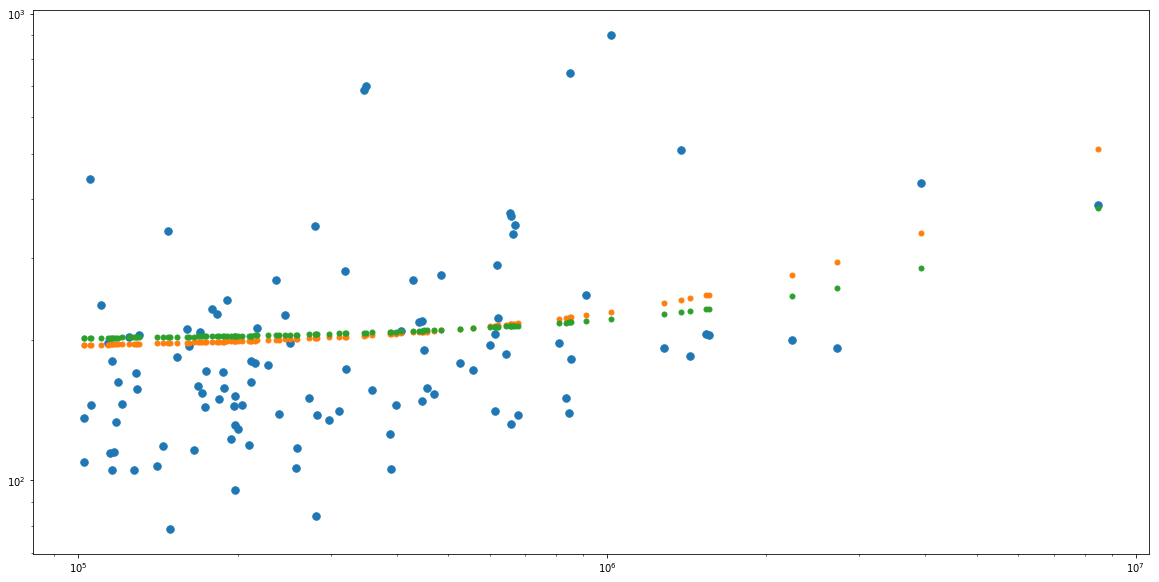

In [18]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
print (pydf.head())
plt.plot(pydf['pop'],pydf['price'],'.',markersize=15)
plt.plot(pydf['pop'],pydf['predA'],'.',markersize=10)
plt.plot(pydf['pop'],pydf['predB'],'.',markersize=10)
plt.xscale('log')
plt.yscale('log')

plt.show()